In [ ]:
!pip install catboost
!pip install optuna

In [ ]:
#import the necessary packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from scipy import stats
from matplotlib.colors import LinearSegmentedColormap

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import IsolationForest

from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from catboost import CatBoostRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold
from sklearn.linear_model import LinearRegression
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import warnings
warnings.filterwarnings("ignore")

In [ ]:
#import the dataset
from google.colab import drive
drive.mount('/content/drive')
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/abalone.csv")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Display shape of the dataset
print("Shape of the dataset:", df.shape)
display(df.head())

Shape of the dataset: (4177, 9)


,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


In [ ]:
# Display basic information
print("Dataset Information:")
print(df.info())

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             4177 non-null   object 
 1   Length          4177 non-null   float64
 2   Diameter        4177 non-null   float64
 3   Height          4177 non-null   float64
 4   Whole weight    4177 non-null   float64
 5   Shucked weight  4177 non-null   float64
 6   Viscera weight  4177 non-null   float64
 7   Shell weight    4177 non-null   float64
 8   Rings           4177 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB
None


In [ ]:
# Display statistical summary
display(df.describe().T)

,count,mean,std,min,25%,50%,75%,max
Length,4177.0,0.523992,0.120093,0.0750,0.4500,0.5450,0.615,0.8150
Diameter,4177.0,0.407881,0.099240,0.0550,0.3500,0.4250,0.480,0.6500
Height,4177.0,0.139516,0.041827,0.0000,0.1150,0.1400,0.165,1.1300
Whole weight,4177.0,0.828742,0.490389,0.0020,0.4415,0.7995,1.153,2.8255
Shucked weight,4177.0,0.359367,0.221963,0.0010,0.1860,0.3360,0.502,1.4880
Viscera weight,4177.0,0.180594,0.109614,0.0005,0.0935,0.1710,0.253,0.7600
Shell weight,4177.0,0.238831,0.139203,0.0015,0.1300,0.2340,0.329,1.0050
Rings,4177.0,9.933684,3.224169,1.0000,8.0000,9.0000,11.000,29.0000


In [ ]:
# Check for missing values
print("Missing values in each column:")
print(df.isnull().sum())

# Check for duplicates
print("\nNumber of duplicate rows:", df.duplicated().sum())

Missing values in each column:
Sex               0
Length            0
Diameter          0
Height            0
Whole weight      0
Shucked weight    0
Viscera weight    0
Shell weight      0
Rings             0
dtype: int64

Number of duplicate rows: 0


In [ ]:
# Display the number of unique values in each column
unique_values = df.nunique()
print(unique_values)

Sex                  3
Length             134
Diameter           111
Height              51
Whole weight      2429
Shucked weight    1515
Viscera weight     880
Shell weight       926
Rings               28
dtype: int64


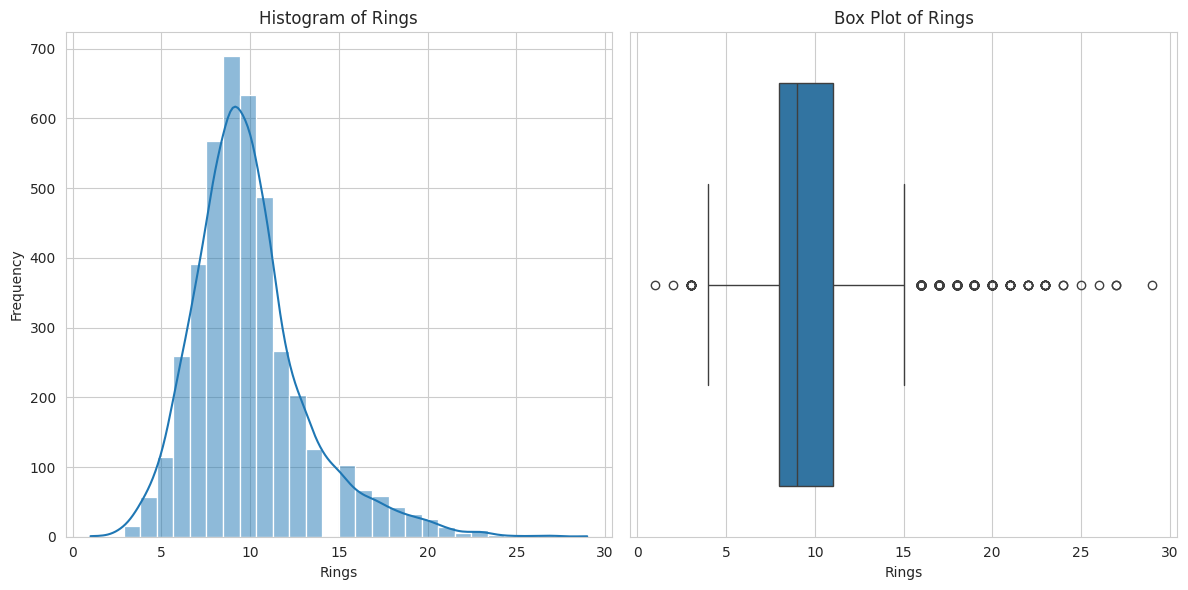

In [ ]:
#Visualize the distribution of the target variable- Rings
sns.set_style("whitegrid")

# Create subplots for histogram and box plot
plt.figure(figsize=(12, 6))

# Histogram for 'Rings'
plt.subplot(1, 2, 1)
sns.histplot(df['Rings'], bins=30, kde=True)
plt.title('Histogram of Rings')
plt.xlabel('Rings')
plt.ylabel('Frequency')

# Box plot for 'Rings'
plt.subplot(1, 2, 2)
sns.boxplot(x=df['Rings'])
plt.title('Box Plot of Rings')
plt.xlabel('Rings')

plt.tight_layout()
plt.show()

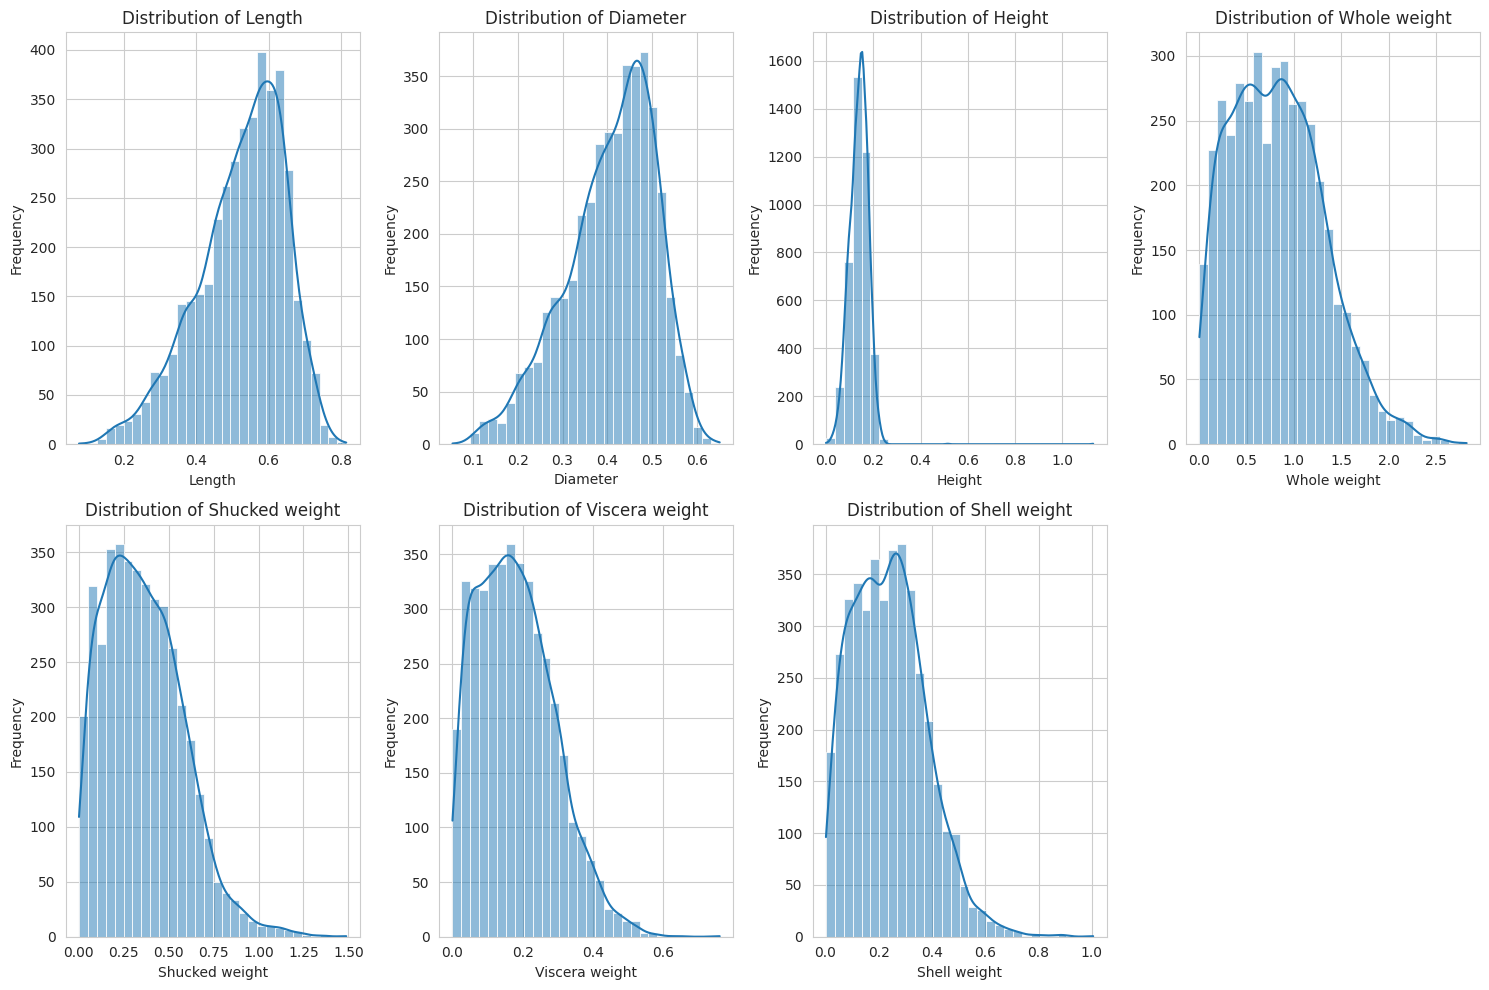

In [ ]:
# Visualize the distribution of the features

features = ['Length', 'Diameter', 'Height', 'Whole weight',
                       'Shucked weight', 'Viscera weight', 'Shell weight']

# Create histograms for each column in the specified list
plt.figure(figsize=(15, 10))
for i, column in enumerate(features):
    plt.subplot(2, 4, i + 1)
    sns.histplot(df[column], bins=30, kde=True)
    plt.title(f'Distribution of {column}')
    plt.xlabel(column)
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()

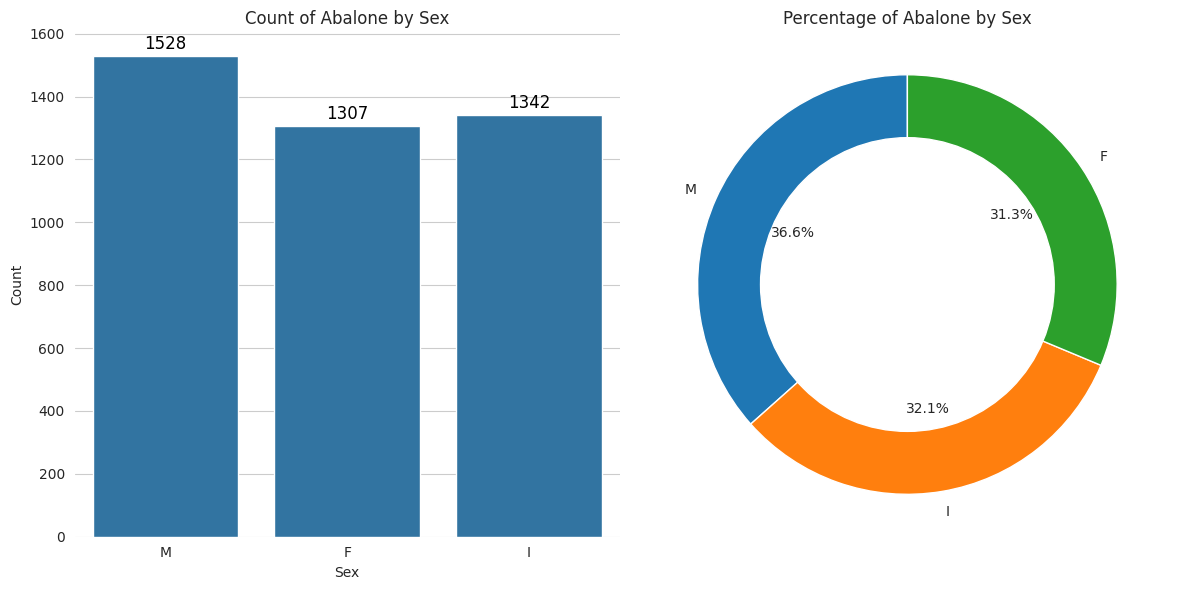

In [ ]:
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Count plot for 'Sex'
sns.countplot(x='Sex', data=df, ax=axes[0])
axes[0].set_title('Count of Abalone by Sex')
axes[0].set_xlabel('Sex')
axes[0].set_ylabel('Count')

for p in axes[0].patches:
    axes[0].annotate(f'{int(p.get_height())}',
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='baseline',
                     color='black', fontsize=12,
                     xytext=(0, 5),
                     textcoords='offset points')

sns.despine(left=True, bottom=True)

# Donut chart for 'Sex'
sex_counts = df['Sex'].value_counts()
wedges, texts, autotexts = axes[1].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90,)

centre_circle = plt.Circle((0, 0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

axes[1].set_title('Percentage of Abalone by Sex')
axes[1].axis('equal')

plt.tight_layout()
plt.show()

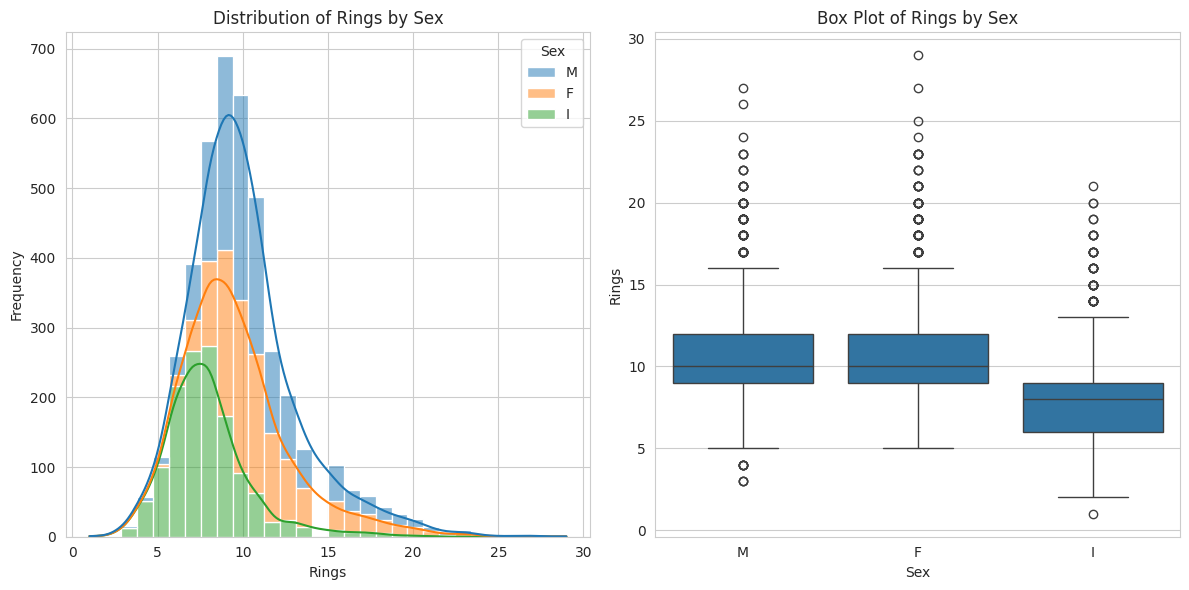

In [ ]:
# Visualize the distribution of ring by sex
# Create a figure with subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Histogram for 'Rings' by 'Sex'
sns.histplot(data=df, x='Rings', hue='Sex', multiple="stack", ax=axes[0], bins=30, kde=True)
axes[0].set_title('Distribution of Rings by Sex')
axes[0].set_xlabel('Rings')
axes[0].set_ylabel('Frequency')

# Box plot for 'Rings' by 'Sex' u
sns.boxplot(x='Sex', y='Rings', data=df, ax=axes[1])
axes[1].set_title('Box Plot of Rings by Sex')
axes[1].set_xlabel('Sex')
axes[1].set_ylabel('Rings')

plt.tight_layout()
plt.show()

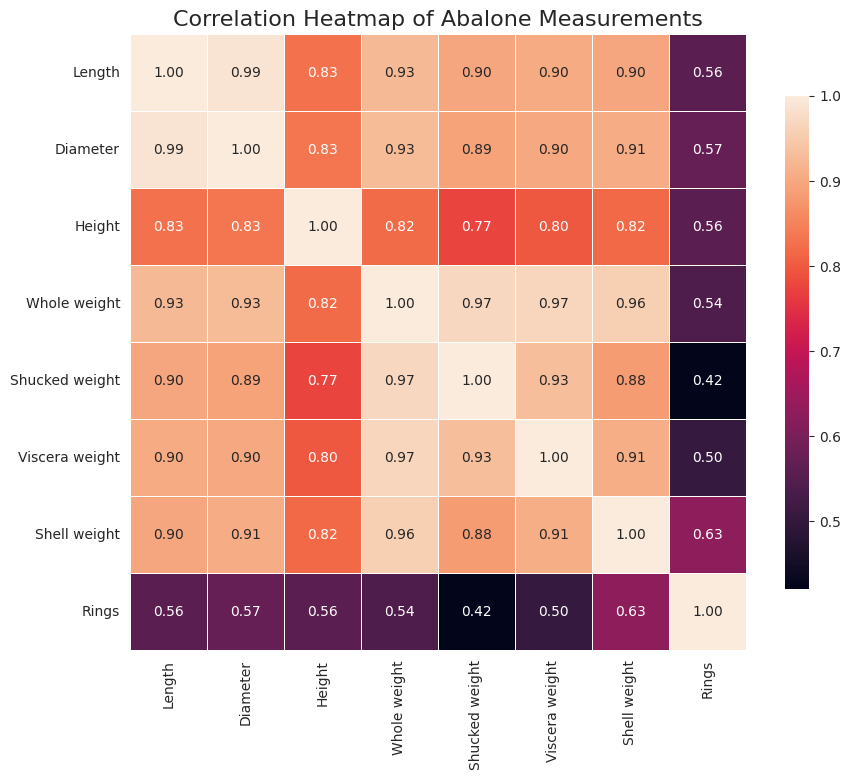

In [ ]:
# Correlation Heatmap
numeric_var = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

# Calculate the correlation matrix
correlation_matrix = df[numeric_var].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f",
            square=True, cbar_kws={"shrink": .8}, linewidths=0.5)

plt.title('Correlation Heatmap of Abalone Measurements', fontsize=16)
plt.show()

In [ ]:
 #one hot encoding for sex
 encoded_df = pd.get_dummies(df, columns=['Sex'], prefix= 'Sex')

In [ ]:
# Split the data into features and target
X = encoded_df.drop(columns=['Rings'])
y = encoded_df['Rings']

# Split the dataset into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Dictionary to store models
models = {
    'XGBoost': XGBRegressor(random_state=42, use_label_encoder=False, eval_metric='rmse'),
    'LGBM': LGBMRegressor(verbose=-1, random_state=42),
    'CatBoost': CatBoostRegressor(verbose=0, random_state=42),
    'RandomForest': RandomForestRegressor(random_state=42)
}

results = {}

# Training and evaluating each model
for model_name, model in models.items():

    # Training the model
    model.fit(X_train, y_train)

    # Making predictions on the test set
    y_pred = model.predict(X_test)

    # Calculating evaluation metrics
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {'MSE': mse, 'R²': r2}

# Display results in a DataFrame for better comparison
results_df = pd.DataFrame(results).T
display(results_df)

,MSE,R²
XGBoost,5.854123,0.459214
LGBM,5.083772,0.530377
CatBoost,5.020707,0.536202
RandomForest,5.089339,0.529862


In [ ]:
def tune_catboost(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.3),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_loguniform('l2_leaf_reg', 1e-2, 10),
    }
    model = CatBoostRegressor(**params, verbose=0, random_state=42)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    return mse

In [ ]:
# CatBoost Study
cat_study = optuna.create_study(direction='minimize')
cat_study.optimize(tune_catboost, n_trials=50)

[I 2025-04-23 18:31:00,701] A new study created in memory with name: no-name-973f976e-b43b-433a-b02c-68471ab7820d
[I 2025-04-23 18:31:02,012] Trial 0 finished with value: 5.312233729304867 and parameters: {'iterations': 267, 'learning_rate': 0.2758068107836741, 'depth': 5, 'l2_leaf_reg': 0.2337320806882193}. Best is trial 0 with value: 5.312233729304867.
[I 2025-04-23 18:31:04,975] Trial 1 finished with value: 5.085037830843527 and parameters: {'iterations': 503, 'learning_rate': 0.11460227208890265, 'depth': 6, 'l2_leaf_reg': 7.43413146096758}. Best is trial 1 with value: 5.085037830843527.
[I 2025-04-23 18:31:05,836] Trial 2 finished with value: 5.30355912280308 and parameters: {'iterations': 446, 'learning_rate': 0.17331828731063192, 'depth': 5, 'l2_leaf_reg': 0.011603254763178297}. Best is trial 1 with value: 5.085037830843527.
[I 2025-04-23 18:31:06,657] Trial 3 finished with value: 4.933983486165722 and parameters: {'iterations': 559, 'learning_rate': 0.07144912197575867, 'depth'

In [ ]:
best_cat_params = cat_study.best_params

# Initialize models with best parameters
cat_model = CatBoostRegressor(**best_cat_params, random_state=42, verbose=0)

# Train model
cat_model.fit(X_train, y_train)

# Predict
cat_pred = cat_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
    #rmse = np.sqrt(mse)
    #mae = mean_absolute_error(y_test, y_pred)
# Train model
cat_model.fit(X_train, y_train)

# Predict
cat_pred = cat_model.predict(X_test)

mse = mean_squared_error(y_test, cat_pred)
    #rmse = np.sqrt(mse)
    #mae = mean_absolute_error(y_true, y_pred)
r2 = r2_score(y_test, cat_pred)

print('MSE:', mse, 'R²:', r2)

MSE: 4.863650704953599 R²: 0.5507107312943513
